In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'

# Set the number of hours to report.
parse = lambda x: pd.to_datetime(x, format='%Y %m %d %H %M')
buoy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=24, 
                        sep='\s+', na_values=['MM', -99], 
                        parse_dates={'Date':['#YY', 'MM', 'DD', 'hh', 'mm']}, 
                        date_parser=parse, index_col = 0)
buoy22_df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
Date,,,,,,,,,,,,,,
2016-12-09 16:50:00,180,5.0,6.0,2.3,9,7.5,262,1020.4,12.3,12.8,11.0,NaN,0.7,NaN
2016-12-09 15:50:00,250,6.0,7.0,2.4,9,7.6,275,1020.4,11.9,12.8,10.8,NaN,1.2,NaN
2016-12-09 14:50:00,220,4.0,6.0,2.1,10,7.4,293,1020.3,13.0,12.7,11.5,NaN,0.7,NaN
2016-12-09 13:50:00,220,6.0,7.0,2.2,9,7.3,253,1019.7,13.0,12.7,11.6,NaN,-0.0,NaN
2016-12-09 12:50:00,200,5.0,6.0,2.1,8,7.1,237,1019.2,12.6,12.8,11.6,NaN,-0.4,NaN


In [189]:
MWD_df = buoy22_df[['WVHT', 'DPD', 'MWD']].copy()
MWD_df = MWD_df.tz_localize('UTC')
MWD_df = MWD_df.tz_convert('US/Pacific')
MWD_df.sort_index(ascending=True, axis=0, inplace=True)
MWD_df.reset_index(inplace=True)
MWD_df['WVHT'] = MWD_df.apply(lambda x: np.around(x['WVHT'] * 3.4, decimals=1), 
                              axis=1)

MWD_df.head()

,Date,WVHT,DPD,MWD
0,2016-12-08 09:50:00-08:00,9.5,9,205
1,2016-12-08 10:50:00-08:00,9.2,9,196
2,2016-12-08 11:50:00-08:00,8.8,9,208
3,2016-12-08 12:50:00-08:00,9.2,9,211
4,2016-12-08 13:50:00-08:00,8.8,9,204


In [190]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,8.100000,8.583333,233.833333
std,0.805416,0.583592,24.911437
min,6.500000,8.000000,196.000000
25%,7.500000,8.000000,214.000000
50%,8.000000,9.000000,234.000000
75%,8.800000,9.000000,253.000000
max,9.500000,10.000000,293.000000


In [192]:
# Get data for plotting
# Convert swell direction from degrees to radians
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Times are indexed with ints starting at 2 so that MWD can be detected.
r = np.arange(len(theta) + 1,  1, -1)

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df[['Date']].iloc[-1].ctime())
tlt_str = 'Buoy 22 Last 24 Hours ' + '\n' + date_str + '\n Hts ' + hts_str

# Get most current data
latest_wht = str(float(MWD_df[['WVHT']].iloc[-1].values))
latest_dpd = str(float(MWD_df[['DPD']].iloc[-1].values))
latest_mwd = str(float(MWD_df[['MWD']].iloc[-1].values))
latest_str = date_str + '\n' + latest_wht + ' ft @ ' + latest_dpd + ' sec' + '\n' + 'Direction: ' + latest_mwd 

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b

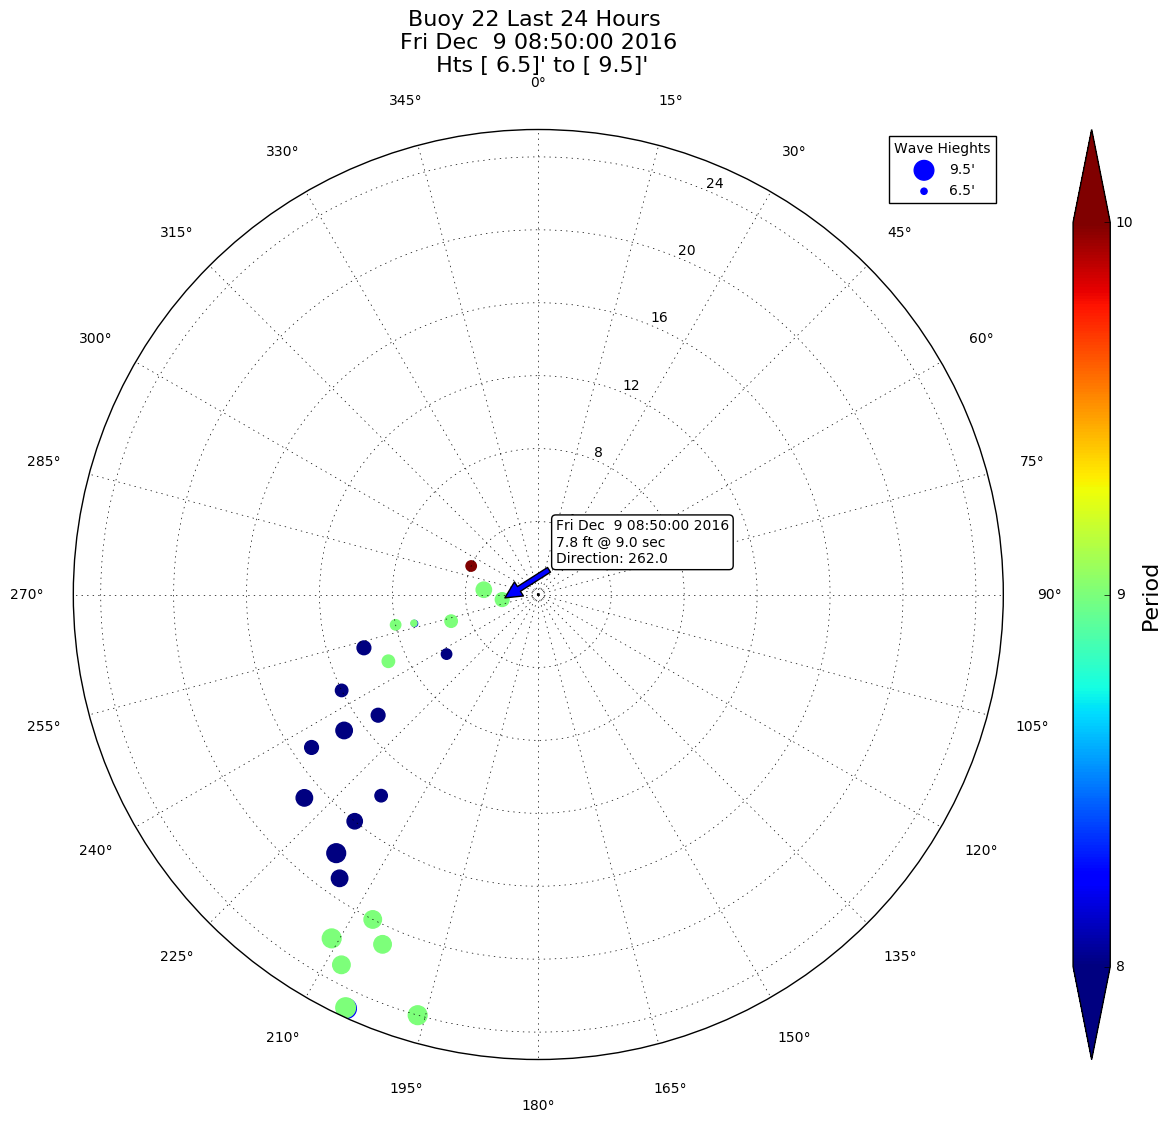

In [193]:
my_plot = plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

big_idx = pnt_sz.idxmax()
small_idx = pnt_sz.idxmin()

big_str = str(float(MWD_df.iloc[big_idx]['WVHT'])) + "'"
small_str = str(float(MWD_df.iloc[small_idx]['WVHT'])) + "'"

#### These two plots are still visable after plotting the main plot. ####
big = ax.scatter(theta.iloc[big_idx], r[int(big_idx)], s=pnt_sz.iloc[big_idx], edgecolors='face')
small = ax.scatter(theta.iloc[small_idx], r[int(small_idx)], s=pnt_sz.iloc[small_idx], edgecolors='face')

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')

cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

thistheta = theta.iloc[-1]
thisr = r[-1]
ax.annotate(latest_str,
            xy=(thistheta, thisr),  # theta, radius
            xytext=(0.5, 2),    # fraction, fraction
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(facecolor='blue', shrink=0.05)
            )

# Plot legend.
lgnd = plt.legend([big_str, small_str], loc="upper right", scatterpoints=1, fontsize=10, title='Wave Hieghts')

plt.show(ax)